In [9]:
# Download and extract data... 
# !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0018/2011_09_26_drive_0018_sync.zip
# !unzip 2011_09_26_drive_0018_sync.zip

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import math
import os
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


In [2]:
def load_points_without_ground(filename):
    points = np.fromfile(filename, dtype=np.float32).reshape(-1, 4)
    points = points[points[:,2] > -1.4]
    points = points[points[:,0] > -80]
    points = points[points[:,0] < 80]
    points = points[points[:,1] > -20]
    points = points[points[:,1] < 20]
    return points

foldername = "2011_09_26_drive_0018_sync"
basepath = os.path.join("2011_09_26", foldername, "velodyne_points/data/")



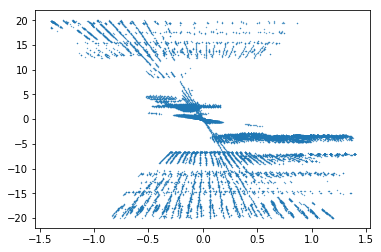

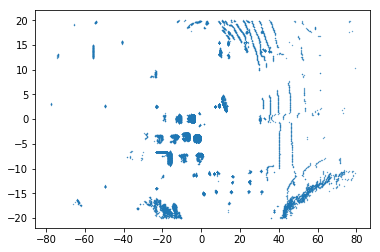

KeyboardInterrupt: 

In [17]:
def transform_into_cartesian_space(points):
    r = np.linalg.norm(points, axis=1)
    
    inclination = np.arccos(points[:,2]/ r)
    # compensate for angular and vertical angle
#     polar_angle = polar_angle - 1.7 #offset: todo what number should this be?
#     polar_angle /= 5 # divide
    azimuth_angle = np.arctan2(points[:,1], points[:,0])
    return np.stack((r, inclination, azimuth_angle), axis=1)

def dbscan(points, eps):
    db = DBSCAN(eps=eps, min_samples=10).fit(points)
    labels = db.labels_    
    return labels

def plot_data(points, labels, filename, axis=None):
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    plt.figure(figsize=(10,10))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = points[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor=tuple(col), markersize=0.5)
    if axis:
        plt.axis(axis) 

    plt.savefig(filename)
    plt.close()
    
    
for filename in os.listdir(basepath):
    complete_path = os.path.join(basepath, filename)
    points = load_points_without_ground(complete_path)
    points = points[:,:3]
    labels = dbscan(points, 0.3)
    plot_data(points, labels, os.path.join("out_images", foldername, "euclidian", filename+".png"), axis=[-80, 80, -20, 20])

    cartesian = transform_into_cartesian_space(points)
    labels = dbscan(cartesian, 0.04)
    plot_data(points, labels, os.path.join("out_images", foldername, "cartesian", filename+".png"), axis=[-80, 80, -20, 20])    
    
    plot_data(cartesian, labels, os.path.join("out_images", foldername, "cartesian_repr", filename+".png"))    

    t = np.copy(cartesian[:,1])
    cartesian[:,1] = cartesian[:,2]
    cartesian[:,2] = t

    x = cartesian[:,0] * np.sin(cartesian[:,1]) * np.cos(cartesian[:,2])
    y = cartesian[:,0] * np.sin(cartesian[:,1]) * np.sin(cartesian[:,2])
    z = cartesian[:,0] * np.cos(cartesian[:,1])
    
    origxy = np.stack((x,y), axis=1)
    plt.scatter(x, y, s=0.1)
    plt.show()
    plt.close()
    
    plt.scatter(points[:,0], points[:,1], s=0.1)
    plt.show()
    plt.close()

    plot_data(cartesian, labels, os.path.join("out_images", foldername, "cartesian_repr_swapped", filename+".png"))    